# Instructions

1. This assignment is worth 5% of the final grade.
2. In the questions below, insert a cell (code or markdown, as appropriate), and fill in your answers there.
2. You are required to work on this individually. Any form of plagiarism will result in 0.
3. Please submit your notebook file (name it `IND5003_A2_<Your_Name>.ipynb`) through Canvas before **17th Nov 2023 23:59hrs**.

# Question 1

In Python, you can save a binary version of an object by pickling it. The file `IND5003_2310_Assignment2.pickle` contains the training and test data that we used in class for the KNN model. The pickle was created in this way:

To read pickled objects into your notebook, you can do this:

In [1]:
import pickle

with open('../data/IND5003_2310_Assignment2.pickle', 'rb') as f:
    X_ttrain, X_ttest, y_train, y_test = pickle.load(f)

If this does not work for you, run the following cell to obtain `X_ttrain`, `X_ttest`, `y_train`, `y_test`.

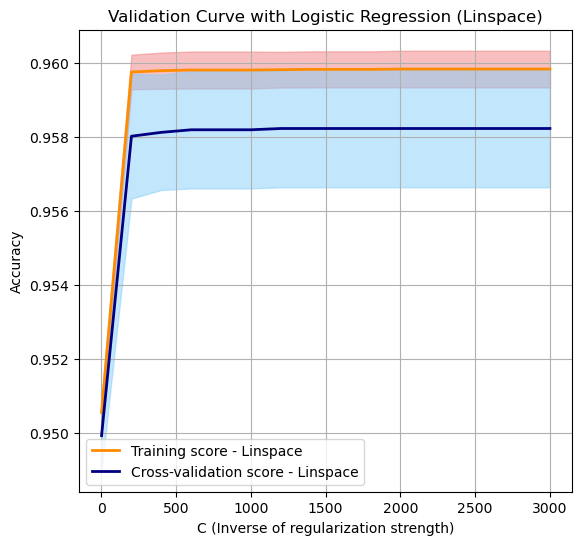

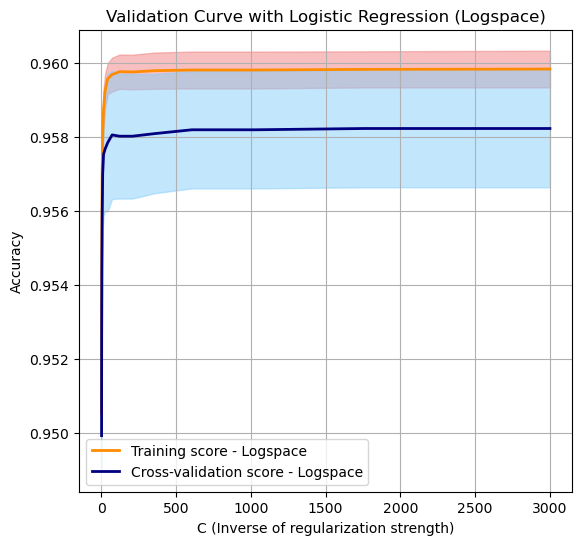

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn import set_config
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

set_config(display='diagram')

loans = pd.read_excel('../data/loans.xlsx', index_col=0)
loans.loc[:, 'issue_yr'] = loans.issue_d.apply(lambda x: x.year)
loans.loc[:, 'issue_mth'] = loans.issue_d.apply(lambda x: x.month)
drop_these_columns = loans.apply(lambda x: np.sum(pd.notna(x)), axis=0) < 40000
loans.drop(columns=loans.columns[drop_these_columns], inplace=True)
no_miss = loans[pd.notna(loans).all(axis=1)].copy()
cr_line_cols = no_miss.earliest_cr_line.str.split('-', expand=True)
cr_line_cols.columns = ['ecrl_mth', 'ecrl_yr']
cr_line_cols.ecrl_yr = cr_line_cols.ecrl_yr.astype(int)
no_miss = pd.concat([no_miss, cr_line_cols], axis=1)
y = no_miss.y
X_train, X_test, y_train, y_test = train_test_split(no_miss, y, test_size=0.3, random_state=41, stratify=y)

num_features = ['loan_amnt', 'int_rate', 'installment', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'issue_yr']
cat_features = ['term', 'grade', 'emp_length', 'home_ownership', 'loan_status', 'purpose', 'addr_state']
all_features = num_features + cat_features
X_train = X_train.loc[:, all_features]
X_test = X_test.loc[:, all_features]
ct = ColumnTransformer([
      ('scale', StandardScaler(), make_column_selector(dtype_include=np.number)),
      ('onehot', OneHotEncoder(), make_column_selector(dtype_include=object))])
ct.fit(X_train)
X_ttrain = ct.transform(X_train)
X_ttest = ct.transform(X_test)

# Create a logistic regression classifier with L2 regularization
logistic_regression = LogisticRegression(random_state=42, solver='saga', penalty='l2')

# Define the range of C values to test
#C_values = np.linspace(1, 3001, num=16)
C_values_lin = np.linspace(1, 3001, num=16)
C_values_log = np.logspace(0, np.log10(3001), num=16)

# Calculate validation curve
train_scores_lin, test_scores_lin = validation_curve(
    logistic_regression, X_ttrain, y_train, param_name="C", param_range=C_values_lin,
    cv=5, scoring="accuracy", n_jobs=-1)

train_scores_log, test_scores_log = validation_curve(
    logistic_regression, X_ttrain, y_train, param_name="C", param_range=C_values_log,
    cv=5, scoring="accuracy", n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean_lin = np.mean(train_scores_lin, axis=1)
train_std_lin = np.std(train_scores_lin, axis=1)

train_mean_log = np.mean(train_scores_log, axis=1)
train_std_log = np.std(train_scores_log, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean_lin = np.mean(test_scores_lin, axis=1)
test_std_lin = np.std(test_scores_lin, axis=1)

test_mean_log = np.mean(test_scores_log, axis=1)
test_std_log = np.std(test_scores_log, axis=1)

# Plot validation curve
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.plot(C_values_lin, train_mean_lin, label="Training score - Linspace", color="darkorange", lw=2)
plt.fill_between(C_values_lin, train_mean_lin - train_std_lin, train_mean_lin + train_std_lin, color="lightcoral", alpha=0.5)
plt.plot(C_values_lin, test_mean_lin, label="Cross-validation score - Linspace", color="navy", lw=2)
plt.fill_between(C_values_lin, test_mean_lin - test_std_lin, test_mean_lin + test_std_lin, color="lightskyblue", alpha=0.5)
plt.title("Validation Curve with Logistic Regression (Linspace)")
plt.xlabel("C (Inverse of regularization strength)")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Plot validation curve
plt.figure(figsize=(14, 6))
plt.subplot(1,2,2)
plt.plot(C_values_log, train_mean_log, label="Training score - Logspace", color="darkorange", lw=2)
plt.fill_between(C_values_log, train_mean_log - train_std_log, train_mean_log + train_std_log, color="lightcoral", alpha=0.5)
plt.plot(C_values_log, test_mean_log, label="Cross-validation score - Logspace", color="navy", lw=2)
plt.fill_between(C_values_log, test_mean_log - test_std_log, test_mean_log + test_std_log, color="lightskyblue", alpha=0.5)
plt.title("Validation Curve with Logistic Regression (Logspace)")
plt.xlabel("C (Inverse of regularization strength)")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()



In [5]:
# Function to create a machine learning pipeline with preprocessing and a given classifier
def create_pipeline_with_features(classifier, num_features, cat_features):
    # Define preprocessing for numeric columns (scale them)
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Define preprocessing for categorical features (encode them)
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Create preprocessing steps by combining numeric and categorical transformations
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_features),
            ('cat', categorical_transformer, cat_features)
        ])

    # Create a pipeline that combines the preprocessor with the classifier
    return Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', classifier)])

# Define the classifiers
best_C_value = 0.89
classifiers = {
    "Logistic Regression": LogisticRegression(C=best_C_value, random_state=42, solver='saga', penalty='l2', max_iter=10000),
    "SVM": SVC(),  # You may choose to exclude this due to long computation times
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=5)  # You can change the number of neighbors
}

# Define numeric and categorical features (make sure these are correctly specified)
num_features = ['loan_amnt', 'int_rate', 'installment', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'issue_yr']
cat_features = ['term', 'grade', 'emp_length', 'home_ownership', 'loan_status', 'purpose', 'addr_state']

# Go through the classifiers and evaluate each
for name, classifier in classifiers.items():
    # Create a pipeline with the current classifier and feature lists
    pipeline = create_pipeline_with_features(classifier, num_features, cat_features)
    
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = pipeline.predict(X_test)
    
    # Evaluate the predictions using confusion matrix, accuracy and F1 score
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')  # Adjust the average method if not binary classification
    
    # Output the results
    print(f"Model: {name}")
    print("Confusion Matrix:")
    print(cm)
    print(f"F1 Score: {f1}")
    print(f"Accuracy Score: {accuracy}\n")

Model: Logistic Regression
Confusion Matrix:
[[9990   63]
 [ 540 1748]]
F1 Score: 0.8528909490119541
Accuracy Score: 0.9511384814844827

Model: SVM
Confusion Matrix:
[[10004    49]
 [  668  1620]]
F1 Score: 0.8188021228203184
Accuracy Score: 0.9419009804715988

Model: Decision Tree
Confusion Matrix:
[[9708  345]
 [ 383 1905]]
F1 Score: 0.8395769061260467
Accuracy Score: 0.9410096426545661

Model: Random Forest
Confusion Matrix:
[[9991   62]
 [ 797 1491]]
F1 Score: 0.7763603228325957
Accuracy Score: 0.9303946195608136

Model: KNN
Confusion Matrix:
[[9859  194]
 [1177 1111]]
F1 Score: 0.6184247147230727
Accuracy Score: 0.8889068957134754



1. A logistic regression classifier is a widely used classification model. It models the log-odds for a class as a linear combination of one or more independent variables. **With L2 regularization,** the hyper-parameter is C, the inverse of regularization strength. Create a sklearn logistic regression classifier with L2 regularization, `random_state=42` and `solver='saga'`, then generate and plot the validation curve by varying C over the range from 1 to 3001 (inclusive of both endpoints) with at least 16 different values.
2. Apply the best estimator to the *test set*, and compare the confusion matrix to the KNN model. In class, it achieved an accuracy of 0.89 and an F1-score of 0.58.

# Question 2

Review the section on 'Running Detections Programmatically' in `08_vision_lecture.ipynb`. Recall that the YOLOv4 model detected 12 objects in `football1.png` and all 12 objects were labeled `person`.

Modify `vision.py` and then use it with the codes in the section on 'Running Detections Programmatically' to detect the objects in `train_station_bournemouth.jpg` and **report all the labels detected and how many objects there were of each label.**

1. In the cell below, include the lines you modify in or/and add to `vision.py` and say where the lines are.
2. Insert other cells after this next cell and fill in the codes you use to detect the objects in `train_station_bournemouth.jpg` and report all the labels detected and how many objects there were of each label.

In [ ]:
# Fill in the details of how you modified vision.py here:
#
# Modify line xxx

# Insert after line yyy


## References

1. The Python [pickle module](https://docs.python.org/3/library/pickle.html)
2. More details on logistic regression - see section 4.3 in [this book](https://www.statlearning.com/).
3. sklearn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) on logistic regression.